In [1]:
import pandas as pd

Load Clean Data

In [2]:
df = pd.read_csv('../data/online_retail_cleaned.csv', parse_dates=['InvoiceDate'], index_col=False)
print('Data is loaded')

Data is loaded


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom,20.40
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,27.80
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,2.60
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom,5.85
4,546157,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom,19.90


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52933 entries, 0 to 52932
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    52933 non-null  int64         
 1   StockCode    52933 non-null  object        
 2   Description  52933 non-null  object        
 3   Quantity     52933 non-null  int64         
 4   InvoiceDate  52933 non-null  datetime64[ns]
 5   UnitPrice    52933 non-null  float64       
 6   CustomerID   39573 non-null  float64       
 7   Country      52933 non-null  object        
 8   Revenue      52933 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.6+ MB


Creating DAILY time series for that product

In [5]:
top_products = (
    df.groupby('StockCode')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_products

StockCode
23166     74698
84077      9419
21175      5032
15036      4684
85099B     4671
21212      3561
22197      3503
22492      3285
84879      2783
17003      2525
Name: Quantity, dtype: int64

Picking one product from here

In [6]:
stock_code = top_products.index[1]  # Select the second top product for variety
stock_code

'84077'

In [7]:
product_df = df[df['StockCode'] == stock_code]

ts_df = (
    product_df.groupby(product_df['InvoiceDate'].dt.date)['Quantity']
    .sum()
    .reset_index()
)

ts_df.columns = ['date', 'daily_sales']
ts_df['date'] = pd.to_datetime(ts_df['date'])

ts_df.head(10)

,date,daily_sales
0,2010-12-02,2880
1,2010-12-10,5
2,2011-01-04,1
3,2011-01-05,288
4,2011-01-31,48
5,2011-02-02,48
6,2011-02-17,96
7,2011-02-20,192
8,2011-03-04,1152
9,2011-03-28,48


In [8]:
# quick sanity check
print(df['StockCode'].dtype)
print(df['StockCode'].value_counts().head(5))

object
StockCode
85123A    219
85099B    205
22423     188
47566     158
84879     150
Name: count, dtype: int64


Filling missing dates

In [9]:
# Set date as index
ts_df = ts_df.set_index('date')

# Create continuous daily frequency
ts_df = ts_df.asfreq('D', fill_value=0)

ts_df.head(15)

,daily_sales
date,
2010-12-02,2880
2010-12-03,0
2010-12-04,0
2010-12-05,0
2010-12-06,0
2010-12-07,0
2010-12-08,0
2010-12-09,0
2010-12-10,5


In [10]:
# quick sanity check
ts_df.describe()

,daily_sales
count,363.000000
mean,25.947658
std,185.596679
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2880.000000


Train–Test Split (time-based)

In [11]:
# Define split point (80% train, 20% test)
split_date = ts_df.index[int(len(ts_df)*0.8)]

train = ts_df.loc[:split_date]
test = ts_df.loc[split_date:]

print(train.shape, test.shape)

(291, 1) (73, 1)


FIRST baseline model — Naive Forecast

Logic: Tomorrow’s sales = Today’s sales

In [12]:
# Naive forecast
naive_forecast = test.copy()
naive_forecast['forecast'] = train['daily_sales'].iloc[-1]

In [13]:
# Evaluate Naive Model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(test['daily_sales'], naive_forecast['forecast'])
rmse = np.sqrt(mean_squared_error(test['daily_sales'], naive_forecast['forecast']))

print(f'Naive Forest MAE: {mae:.2f}')
print(f'Naive Forest RMSE: {rmse:.2f}')

Naive Forest MAE: 16.51
Naive Forest RMSE: 48.71


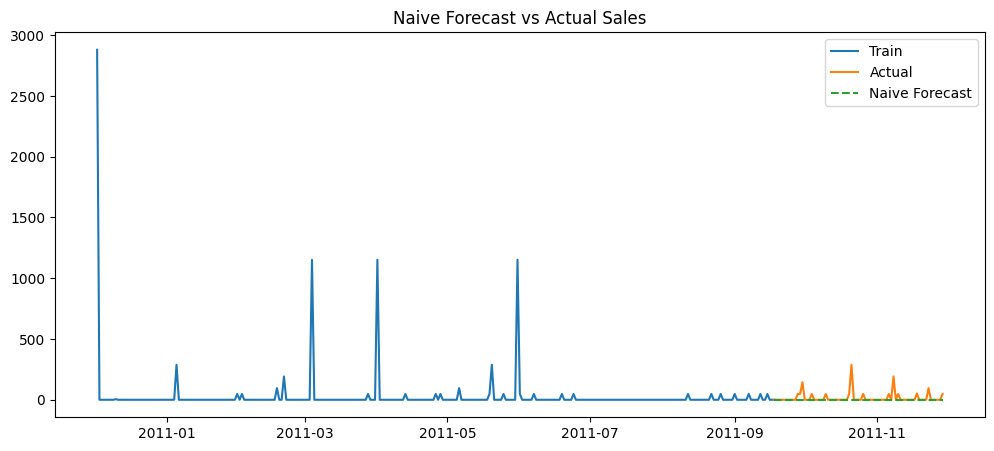

In [14]:
# Plot Actual vs Naive Forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train.index, train['daily_sales'], label='Train')
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, naive_forecast['forecast'], '--', label='Naive Forecast')
plt.legend()
plt.title('Naive Forecast vs Actual Sales')
plt.show()

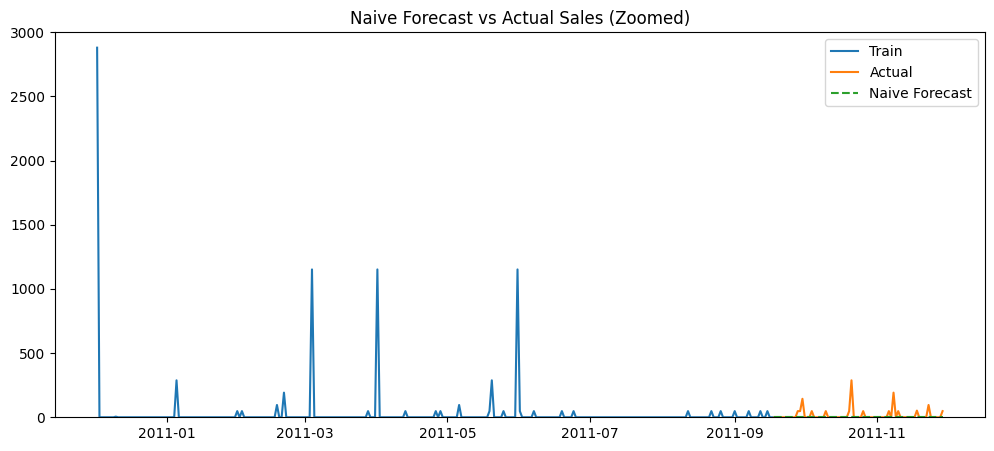

In [15]:
# Plot without extreme spike (zoomed view)
plt.figure(figsize=(12,5))
plt.plot(train.index, train['daily_sales'], label='Train')
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, naive_forecast['forecast'], '--', label='Naive Forecast')

plt.ylim(0, 3000)  # adjust if needed
plt.legend()
plt.title('Naive Forecast vs Actual Sales (Zoomed)')
plt.show()


* The Naive forecasting model achieved an MAE of 16.51 and an RMSE of 48.71.
* The large RMSE indicates sensitivity to demand spikes, confirming that the Naive model is insufficient for capturing trends and seasonality. 
* This baseline establishes a reference point for evaluating more advanced time-series models.

* The naive forecast serves as a baseline by assuming future demand equals the most recent observed value.
* As expected, it fails to capture demand volatility and sudden spikes common in retail sales.

Moving Average Baseline model

In [31]:
# using weekly window
window = 7

# Moving Average based on training data
ma_value =  train['daily_sales'].rolling(window).mean().iloc[-1]

ma_forecast = test.copy()
ma_forecast['forecast'] = ma_value

In [32]:
# Evaluate Moving Average
ma_mae = mean_absolute_error(test['daily_sales'], ma_forecast['forecast'])
ma_rsme = np.sqrt(mean_squared_error(test['daily_sales'], ma_forecast['forecast']))

print(f'Moving Average MAE: {ma_mae:.2f}')
print(f'Moving Average RMSE: {ma_rsme:.2f}')

Moving Average MAE: 24.93
Moving Average RMSE: 45.91


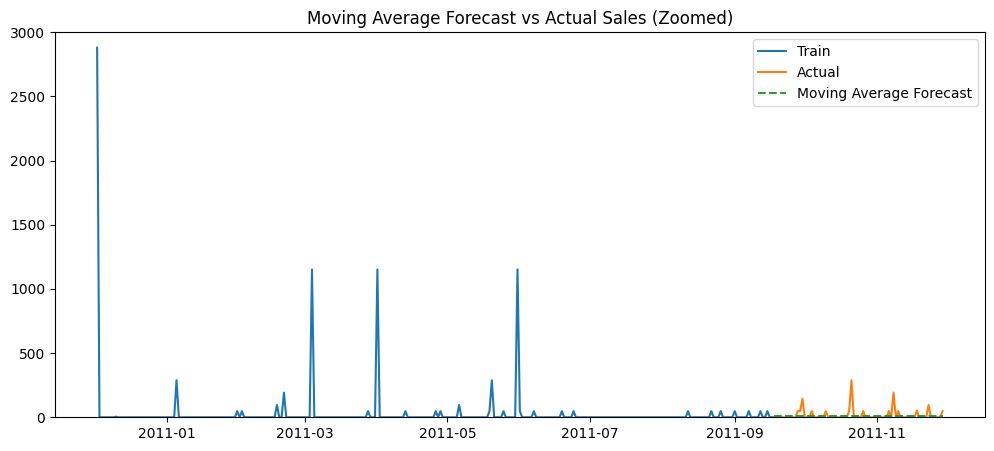

In [33]:
# Plot MA vs Actual (Zoomed)
plt.figure(figsize=(12,5))
plt.plot(train.index, train['daily_sales'], label='Train')
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, ma_forecast['forecast'], '--', label='Moving Average Forecast')
plt.ylim(0, 3000)
plt.legend()
plt.title('Moving Average Forecast vs Actual Sales (Zoomed)')
plt.show()

Now Rolling / Dynamic Moving Average Forecast (Improved version)

In [ ]:
# Combine train + test history
history = train['daily_sales'].copy()
predictions = []

# Forecast one step at a time
window = 7

for actual in test['daily_sales']:
    ma_pred = history[-window:].mean()
    predictions.append(ma_pred)
    history = pd.concat([history, pd.Series([actual], index=[history.index[-1] + pd.Timedelta(days=1)])])

# Store predictions
ma_forecast = test.copy()
ma_forecast['forecast'] = predictions

In [ ]:
# Re-evaluate
ma_mae = mean_absolute_error(test['daily_sales'], ma_forecast['forecast'])
ma_rmse = np.sqrt(mean_squared_error(test['daily_sales'], ma_forecast['forecast']))

print(f"Rolling MA MAE : {ma_mae:.2f}")
print(f"Rolling MA RMSE: {ma_rmse:.2f}")


Rolling MA MAE : 27.70
Rolling MA RMSE: 50.46


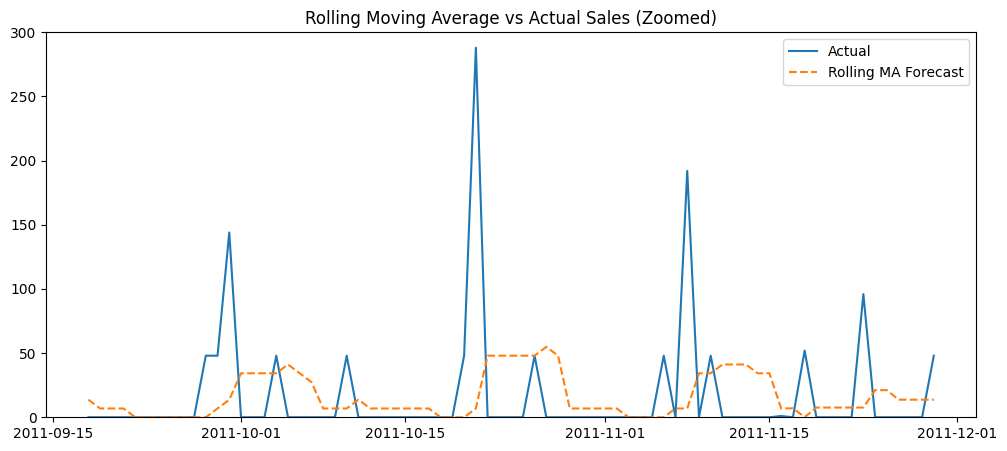

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, ma_forecast['forecast'], '--', label='Rolling MA Forecast')
plt.ylim(0, 300)
plt.legend()
plt.title('Rolling Moving Average vs Actual Sales (Zoomed)')
plt.show()


* Rolling Moving Average adapts to recent demand changes but lags during sudden spikes.
* In sparse retail data with many zero-sales days, this can increase error compared to a naive baseline that predicts constant low demand.

TO be continued...